# Подготовка данных и модели

In [ ]:
# импорт библиотек
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from typing import Literal
from io import StringIO
from statsmodels import api as sm
from scipy import stats
from plotly import express as px

In [ ]:
csv_raw = '''
"date","value"
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136
1949-10-01,119
1949-11-01,104
1949-12-01,118
1950-01-01,115
1950-02-01,126
1950-03-01,141
1950-04-01,135
1950-05-01,125
1950-06-01,149
1950-07-01,170
1950-08-01,170
1950-09-01,158
1950-10-01,133
1950-11-01,114
1950-12-01,140
1951-01-01,145
1951-02-01,150
1951-03-01,178
1951-04-01,163
1951-05-01,172
1951-06-01,178
1951-07-01,199
1951-08-01,199
1951-09-01,184
1951-10-01,162
1951-11-01,146
1951-12-01,166
1952-01-01,171
1952-02-01,180
1952-03-01,193
1952-04-01,181
1952-05-01,183
1952-06-01,218
1952-07-01,230
1952-08-01,242
1952-09-01,209
1952-10-01,191
1952-11-01,172
1952-12-01,194
1953-01-01,196
1953-02-01,196
1953-03-01,236
1953-04-01,235
1953-05-01,229
1953-06-01,243
1953-07-01,264
1953-08-01,272
1953-09-01,237
1953-10-01,211
1953-11-01,180
1953-12-01,201
1954-01-01,204
1954-02-01,188
1954-03-01,235
1954-04-01,227
1954-05-01,234
1954-06-01,264
1954-07-01,302
1954-08-01,293
1954-09-01,259
1954-10-01,229
1954-11-01,203
1954-12-01,229
1955-01-01,242
1955-02-01,233
1955-03-01,267
1955-04-01,269
1955-05-01,270
1955-06-01,315
1955-07-01,364
1955-08-01,347
1955-09-01,312
1955-10-01,274
1955-11-01,237
1955-12-01,278
1956-01-01,284
1956-02-01,277
1956-03-01,317
1956-04-01,313
1956-05-01,318
1956-06-01,374
1956-07-01,413
1956-08-01,405
1956-09-01,355
1956-10-01,306
1956-11-01,271
1956-12-01,306
1957-01-01,315
1957-02-01,301
1957-03-01,356
1957-04-01,348
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404
1957-10-01,347
1957-11-01,305
1957-12-01,336
1958-01-01,340
1958-02-01,318
1958-03-01,362
1958-04-01,348
1958-05-01,363
1958-06-01,435
1958-07-01,491
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420
1959-06-01,472
1959-07-01,548
1959-08-01,559
1959-09-01,463
1959-10-01,407
1959-11-01,362
1959-12-01,405
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432
'''

Датасет содержит данные об объеме пассажирских авиаперевозок за указанные 12 лет по месяцам.

In [ ]:
df = pd.read_csv(StringIO(csv_raw)) # загружаем датасет из строкового формата

In [ ]:
def get_forecast(data, forecast_horizon): # обертка для ExponentialSmoothing
    model = ExponentialSmoothing(
        data,
        trend='add', # линейный тренд - предполагаем линейный рост
        damped_trend=True, # предполагаем затухание роста
        seasonal='add', # предполагаем линейный рост от сезона к сезону
        seasonal_periods=12, # 12 месяцев в году
        initialization_method='heuristic' # начальные параметры определяются при помощи эвристики
    )

    fit_model = model.fit( # фитим модель
        optimized=True
    )

    forecast = fit_model.forecast(forecast_horizon) # строим предсказание

    return forecast

In [ ]:
df.__len__()

144

In [ ]:
y_train = df[:108].value # первые 9 лет берем в качестве исходных данных
y_test = df[108:144].value # оставшиеся 3 предсказываем

y_pred = get_forecast(y_train, 36)
residuals = y_test - y_pred

# Runs test для остатков

In [ ]:
# runs test
med = residuals.median()
signs = np.sign(residuals - med)
signs = signs[signs != 0]
runs = np.sum(np.diff(signs) != 0) + 1
n = len(signs)
n_pos = np.sum(signs > 0)
n_neg = np.sum(signs < 0)
exp_runs = (2 * n_pos * n_neg / n) + 1
var_runs = (2 * n_pos * n_neg * (2 * n_pos * n_neg - n)) / (n ** 2 * (n - 1))
z = (runs - exp_runs) / np.sqrt(var_runs) if var_runs > 0 else 0
p_val = 2 * (1 - stats.norm.cdf(abs(z)))

f'runs: {runs}, exp_runs: {exp_runs}, z: {z}, p_value: {p_val}'

'runs: 9, exp_runs: 19.0, z: -3.3819977079726162, p_value: 0.0007196074502873184'

Фактическое число серий меньше ожидаемого, т.е. остатки сгруппированы по знакам, а полученное значение Z-статистикм при p << 0.05 указывает на наличие отклонения от случайного порядка.

Результат свидетельствует о неслучайных систематических ошибках модели.

# Нормальность распределения остатков

In [ ]:
skew = stats.skew(residuals) # асимметрия
kurt = stats.kurtosis(residuals) # эксцесс
d_stat, p_value = stats.kstest(residuals, 'norm') # критерий Колмогорова-Смирнова

f'асимметрия: {skew}, эксцесс: {kurt}, d-статистика: {d_stat}, p-value: {p_value}'

'асимметрия: 0.7711569250037968, эксцесс: 0.3145475309728418, d-статистика: 0.7221312184132157, p-value: 1.381229361586189e-19'

Высокое значение D-статистики при p << 0.05 указывает на сильное отклонение распределения остатков от нормального.

In [ ]:
n = len(y_test)
Sa = 6 * (n - 2) / ((n + 1) * (n + 3))
Se = 24 * n * (n - 2) * (n - 3) / ((n + 1) ** 2 * (n + 3) * (n + 5))

print('Проверка нормальности остатков на основе асимметрии и эксцесса: ')
if skew <= 1.5 * Sa and kurt <= 1.5 * Se:
    print('Остатки нормально распределены')
elif skew >= 2 * Sa and kurt > 2 * Se:
    print('Остатки имеют распределение, отличное от нормального')
else:
    print('Невозможно сделать вывод на основе представленных данных')

Проверка нормальности остатков на основе асимметрии и эксцесса: 
Невозможно сделать вывод на основе представленных данных


# Тест Дарбина-Уотсона

In [ ]:
dw = sm.stats.durbin_watson(residuals) # тест дарбина-уотсона

f'результат теста Дарбина-Уотсона: {dw}'

'результат теста Дарбина-Уотсона: 0.5139841385539006'

Число предикторов (k) = 3 (тренд + сезонность + уровень)
Число периодов, для которых строится предсказание: 36

Исходя из таблицы (https://assets-zebra.zanichelli.it/ea4910bf-41a5-4e36-929e-1f040a8fa1aa-durbin-watson-tables-5-per-cent.pdf)

dL = 1.295
dH = 1.654

Результат теста = 0.514

In [ ]:
dl = 1.295
dh = 1.654

print('Интерпретация теста Дарбина-Уотсона:')
if 4 - dl <= dw and dw <= 4:
    print('Отрицательная автокорреляция')
elif 4 - dh <= dw and dw < 4 - dh or dl <= dw and dw < dh:
    print('Невозможно сделать вывод на заданном уровне значимости')
elif dh <= dw and dw < 4 - dh:
    print('Автокорреляция отсутствует')
elif 0 <= dw and dw < dl:
    print('Положительная автокорреляция')

Интерпретация теста Дарбина-Уотсона:
Положительная автокорреляция


# t-критерий Стьюдента

In [ ]:
t_stat, p_val = stats.ttest_1samp(residuals, 0) # t-тест о равенстве среднего значения остатков нулю

f't-статистика: {t_stat}, p-value: {p_val}'

't-статистика: -3.5386857083959273, p-value: 0.0011575790153358421'

Полученное значение t-статистики при p < 0.05 говорит об отклонении среднего остатков от нуля.

По результатам всех примененных тестов делаем вывод о низкой предсказательной способности модели.

# График

In [ ]:
graph_values = pd.concat((df.value, y_pred), axis=1) # объединяем реальные и предсказанные значения
graph_values.columns = ['true', 'predicted'] # переименовываем столбцы
px.scatter(data_frame=graph_values) # строим точечную диаграмму

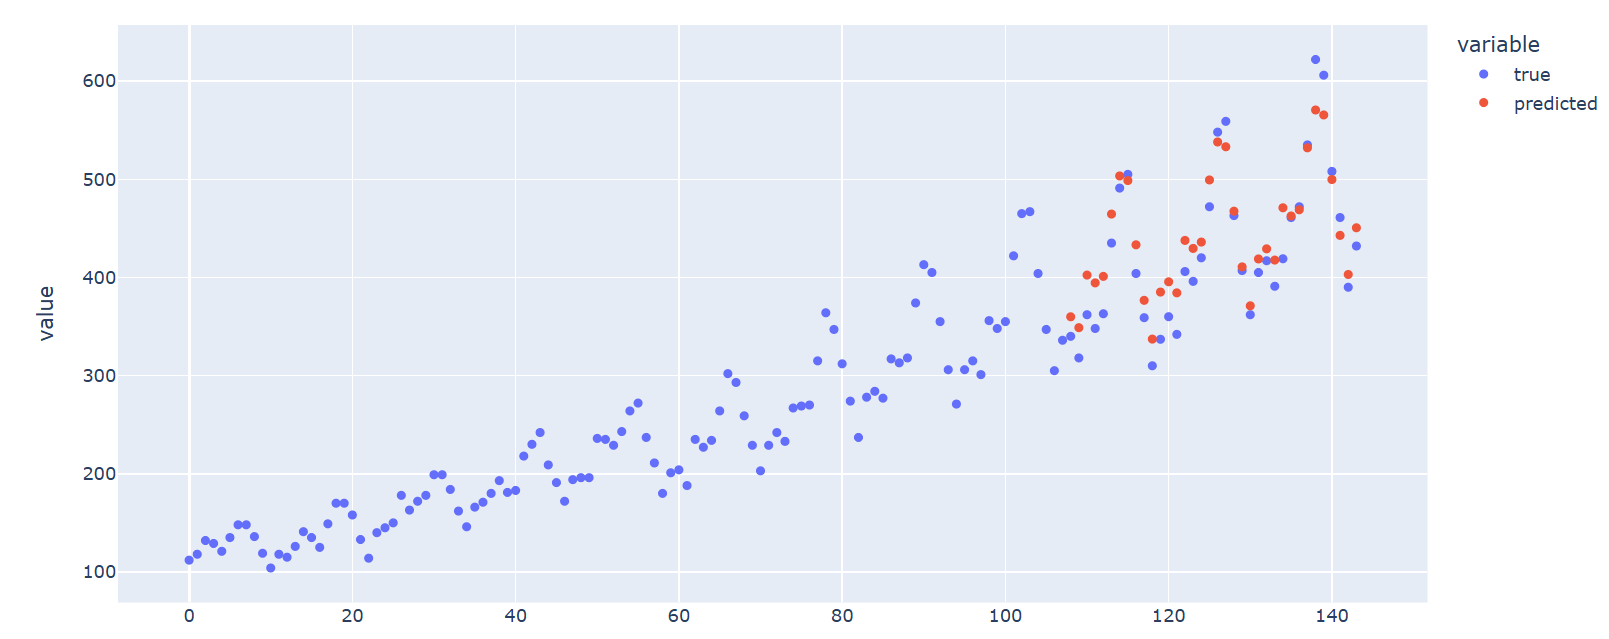